In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


ImportError: attempted relative import with no known parent package

# Import data from influx and update the file name below

This specifically is a template to take in the robot state data, not gyro, accel, wheel position, etc.

In [11]:
# Load the CSV while skipping metadata rows
df = pd.read_csv('influx.data.csv', comment='#')

# Convert the '_time' column to relative seconds
df["_time"] = pd.to_datetime(df["_time"])
df["_time"] = (df["_time"] - df["_time"].iloc[0]).dt.total_seconds()

attr_map = {
    ("state/angles", "x"):          "x",
    ("state/angles", "x_dot"):      "x_dot",
    ("state/angles", "y"):          "y",
    ("state/angles", "y_dot"):      "y_dot",
    ("state/angles", "z"):          "z",
    ("state/angles", "z_dot"):      "z_dot",
    ("motor/pitch", "velocity"):    "pitch_velocity",
    ("motor/pitch", "torque"):      "pitch_torque",
    ("motor/roll",  "velocity"):    "roll_velocity",
    ("motor/roll",  "torque"):      "roll_torque",
}

def map_attributes(row):
    return attr_map.get((row["_measurement"], row["_field"]), None)

df["attribute"] = df.apply(map_attributes, axis=1)

# Split the dataframe into groups based on the "attribute" column
grouped = df.groupby("attribute", dropna=True)

# Dictionary of { attribute: DF with columns [_time, attribute] }
dfs = {}
for attr, subdf in grouped:
    # keep only two columns: time and value
    subdf = subdf[["_time", "_value"]].sort_values("_time")
    # rename "_value" => the attribute name
    subdf = subdf.rename(columns={"_value": attr})
    dfs[attr] = subdf

# 'x' as the reference time
reference_attr = "x"
if reference_attr not in dfs:
    raise ValueError(f"Reference attribute '{reference_attr}' not found! Choose another reference attribute.")

df_ref = dfs[reference_attr].copy()  # columns: [_time, "x"]
df_ref = df_ref.sort_values("_time")  # ensure sorted by time

# Merge all other attributes with the reference attribute
df_aligned = df_ref
for attr, subdf in dfs.items():
    if attr == reference_attr:
        continue
    
    # subdf = columns: [_time, attr], also sorted by _time
    subdf = subdf.sort_values("_time")
    
    # Use merge_asof to align times to the reference's timeline
    # direction='nearest' picks the closest time on subdf
    # tolerance=... can be added if you want to exclude big mismatches
    df_aligned = pd.merge_asof(
        df_aligned,
        subdf,
        on="_time",
        direction="nearest",
        # e.g., tolerance=0.01 if you only trust merges within 0.01 seconds
    )

# Reorder columns
desired_col_order = [
    "x", "x_dot", 
    "y", "y_dot", 
    "z", "z_dot",
    "pitch_velocity", "roll_velocity",
    "pitch_torque",   "roll_torque"
]

df_aligned = df_aligned[["_time"] + [c for c in desired_col_order if c in df_aligned]]

# Scale the angles to be in radians
df_aligned["x"] = np.deg2rad(df_aligned["x"])
df_aligned["y"] = np.deg2rad(df_aligned["y"])
df_aligned["z"] = np.deg2rad(df_aligned["z"])
df_aligned["x_dot"] = np.deg2rad(df_aligned["x_dot"])   
df_aligned["y_dot"] = np.deg2rad(df_aligned["y_dot"])
df_aligned["z_dot"] = np.deg2rad(df_aligned["z_dot"])

# df_aligned has one row per "x" reading time, with the nearest data from all other attributes
# print(df_aligned.head(6))

## Plotting a specific state variable over time

In [12]:
# Plot x versus time
# xs = df_aligned["roll_velocity"]
# ts = xs.index
# plt.plot(ts, xs)
# plt.xlabel("Timestep")
# plt.ylabel("X angle (rad)")
# plt.title("X angle versus time")
# plt.show()

## Computing the state at the next step with our system dynamics

In [13]:
def compute_next_state(row_current, row_next, A, B, K):
    """
    row_current: a Series containing time, x, x_dot, roll_velocity, y, y_dot, pitch_velocity, ...
    row_next:    a Series for the next row (used to find dt = time difference).
    
    Returns a dictionary of computed_{...} values for the next state 
    *and* the torque used at the current time step.
    """
    # 1) Compute dt from the difference in times
    t_curr = row_current["_time"]
    t_next = row_next["_time"]
    dt = t_next - t_curr
    if dt < 1e-12:
        dt = 0.0  # if zero or negative, edge case
    
    # 2) Build the 6D state vector from the current row
    # Adjust if your 'x' is roll angle, 'x_dot' is roll rate, etc.
    x_k = np.array([
        row_current["x"],           # roll angle
        row_current["x_dot"],       # roll rate
        row_current["roll_velocity"],
        row_current["y"],           # pitch angle
        row_current["y_dot"],       # pitch rate
        row_current["pitch_velocity"],
    ], dtype=float)
    
    # 3) Compute torque
    # If K is 2x6, we get [rollTorque, pitchTorque]
    torque = K @ x_k
    
    # 4) Next-state derivative
    x_dot_k = A @ x_k + B @ torque
    
    # 5) Euler integration step
    x_k_next = x_k + x_dot_k * dt
    
    # 6) Package results in a dict
    # We’ll store the “predicted next state” in fields like computed_x, computed_x_dot, etc.
    # We'll also store the torque as computed_roll_torque and computed_pitch_torque
    return {
        "computed_roll_torque":  torque[0],
        "computed_pitch_torque": torque[1],
        
        "computed_x":              x_k_next[0],
        "computed_x_dot":          x_k_next[1],
        "computed_roll_velocity":  x_k_next[2],
        "computed_y":              x_k_next[3],
        "computed_y_dot":          x_k_next[4],
        "computed_pitch_velocity": x_k_next[5],
    }

In [17]:
LQR = LQRController()

In [ ]:
A = np.array([
    [0.0,   1.0,   0.0,   0.0,   0.0,   0.0],
    [36.57, 0.0,   0.0,   0.0,   0.0,   0.0],
    [-36.57,0.0,   0.0,   0.0,   0.0,   0.0],
    [0.0,   0.0,   0.0,   1.0,   0.0,   0.0],
    [0.0,   0.0,  16.64,  0.0,   0.0,   0.0],
    [0.0,   0.0,-1.203,   0.0,   0.0,   0.0],
])
B = np.array([
    [ 0.0,   0.0],
    [-14.2,  0.0],
    [1316.3, 0.0],
    [ 0.0,   0.0],
    [ 0.0,  -3.21],
    [ 0.0,  17.63],
])

print(LQR._K)
print(LQR._K[0, 0])

K = np.array([
    [LQR._K[0, 0], LQR._K[0, 3], LQR._K[0, 6], 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, LQR._K[1, 1], LQR._K[1, 4], LQR._K[1, 7]]
])

# K = np.array([
#     [-8.24747166e+00, -1.12211044e+00, -4.47213595e-03, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0, -3.53333333e+00, -2.53920000e-01, 5.90000000e-03]
# ])

for col in [
    "computed_roll_torque", "computed_pitch_torque",
    "computed_x", "computed_x_dot", "computed_roll_velocity", 
    "computed_y", "computed_y_dot", "computed_pitch_velocity"
]:
    df_aligned[col] = np.nan  # Initialize with NaN

# We'll do a pairwise iteration: row i => row i+1
for i in range(len(df_aligned) - 1):
    row_current = df_aligned.iloc[i]
    row_next = df_aligned.iloc[i+1]
    
    results = compute_next_state(row_current, row_next, A, B, K)
    
    # We store the results in row i+1, so we can compare "computed" vs "actual" at i+1
    for k, v in results.items():
        df_aligned.at[i+1, k] = v

[0.44, 0.019, -0.05]


TypeError: list indices must be integers or slices, not tuple

### Look at the error between model prediction and reality as measured

In [63]:
df_aligned["error_x"] = df_aligned["computed_x"] - df_aligned["x"]
df_aligned["error_y"] = df_aligned["computed_y"] - df_aligned["y"]
df_aligned["error_x_dot"] = df_aligned["computed_x_dot"] - df_aligned["x_dot"]
df_aligned["error_y_dot"] = df_aligned["computed_y_dot"] - df_aligned["y_dot"]
df_aligned["error_roll_velocity"] = df_aligned["computed_roll_velocity"] - df_aligned["roll_velocity"]
df_aligned["error_pitch_velocity"] = df_aligned["computed_pitch_velocity"] - df_aligned["pitch_velocity"]

# Inspect
print(df_aligned[["x", "computed_x", "error_x"]].head(6))

          x  computed_x   error_x
0  2.564911         NaN       NaN
1  2.661560    2.564905 -0.096655
2  2.705358    2.661298 -0.044060
3  2.780876    2.705357 -0.075518
4  2.782675    2.780852 -0.001822
5  2.839097    2.782748 -0.056348


## Plot from robot states as measured and as computed by system dynamics

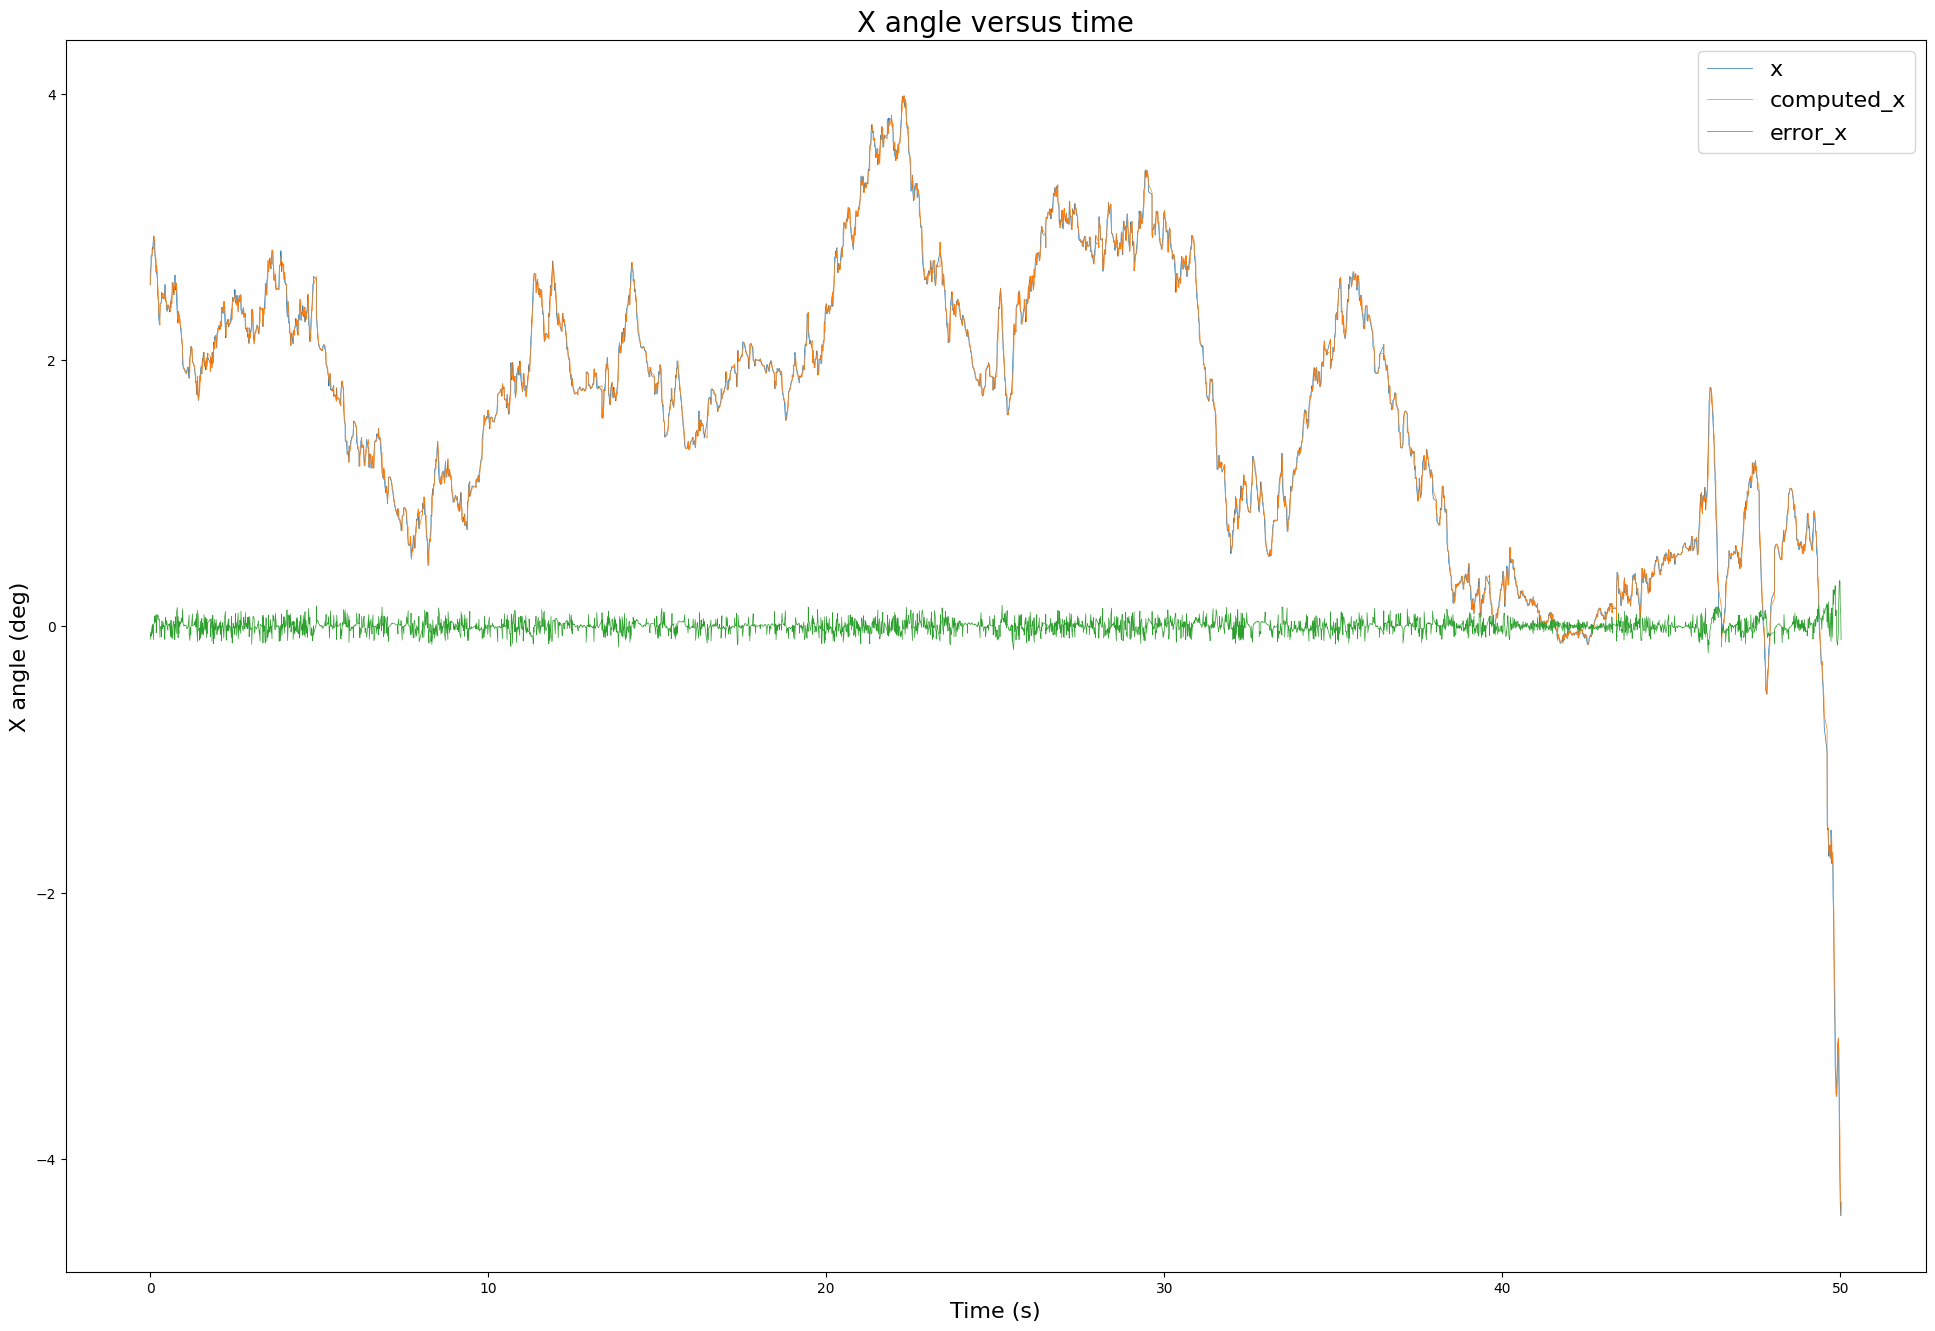

In [ ]:
# plot x, computed_x, error_x
plt.figure(figsize=(24, 16))
plt.plot(df_aligned["_time"], np.rad2deg(df_aligned["x"]), label="x", linewidth=0.5)
plt.plot(df_aligned["_time"], np.rad2deg(df_aligned["computed_x"]), label="computed_x", linewidth=0.5)
plt.plot(df_aligned["_time"], np.rad2deg(df_aligned["error_x"]), label="error_x", linewidth=0.5)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("X angle (deg)", fontsize=16)
plt.title("X angle versus time", fontsize=20)
plt.legend(fontsize=16)
plt.show()